In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip

In [2]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
"""with ZipFile("archive.zip","r") as zip:
    zip.extractall()"""

'with ZipFile("archive.zip","r") as zip:\n    zip.extractall()'

In [4]:
batch_size = 32
img_size = (128,128)

In [5]:
train_ds = image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    "val",
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

class_names = train_ds.class_names

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

Found 357507 files belonging to 2 classes.
Found 71504 files belonging to 2 classes.


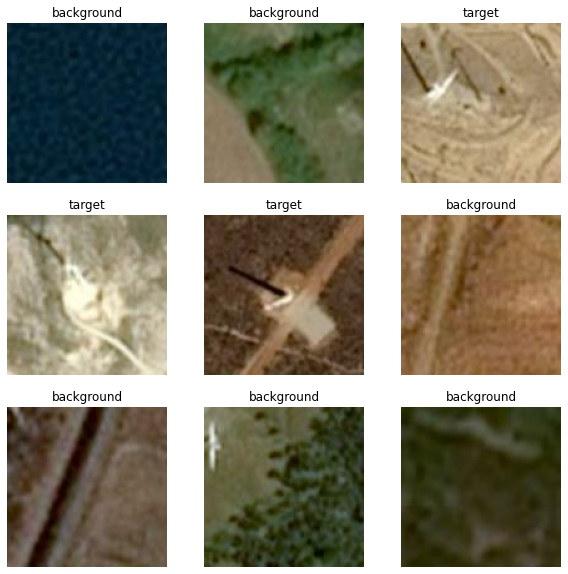

In [6]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
])

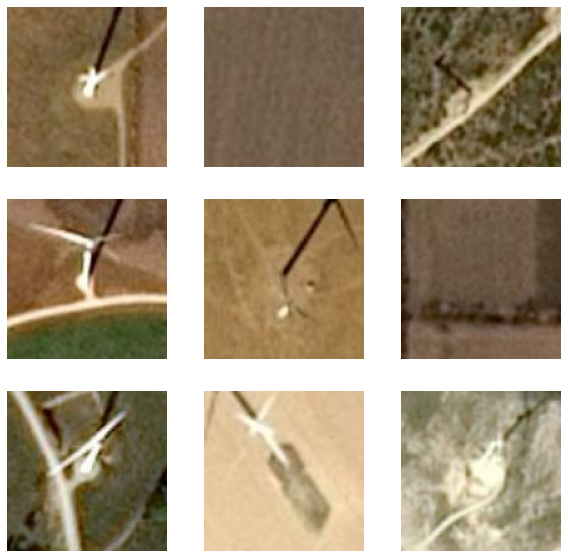

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Build the model

In [10]:
from tensorflow.keras.applications import efficientnet, EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [11]:
preprocess_input = efficientnet.preprocess_input
input_shape = img_size+(3,)
base_model = EfficientNetB3(input_shape=input_shape,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

feature_batch_average = GlobalAveragePooling2D()(feature_batch)
prediction_batch = Dense(2)(feature_batch_average)

def model():
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x,training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2,seed=123)(x)
    outputs = Dense(2)(x)
    model = tf.keras.Model(inputs,outputs)
    return model

model = model()
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 4, 4, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3074      
Total params: 10,786,609
Trainable params: 3,074
Non-trainable params: 10,783,535
_____________________________________________

### Train and evaluate the model on test dataset

In [12]:
if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    checkpoint = ModelCheckpoint("airbus.hdf5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=3,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("airbus.hdf5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nTest accuracy: {:.2f} %".format(100*accuracy))
    print("Test loss {:.2f} %".format(100*loss))

1788/1788 [==============================] - 145s 79ms/step - loss: 0.6277 - accuracy: 0.6471
Epoch 1/3
11173/11173 [==============================] - 1021s 91ms/step - loss: 0.0976 - accuracy: 0.9625 - val_loss: 0.0778 - val_accuracy: 0.9711


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/3
11173/11173 [==============================] - 1015s 91ms/step - loss: 0.0923 - accuracy: 0.9649 - val_loss: 0.0761 - val_accuracy: 0.9718
Epoch 3/3
447/447 [==============================] - 36s 78ms/step - loss: 0.0755 - accuracy: 0.9720

Test accuracy: 97.20 %
Test loss 7.55 %
